# 3 layer LSTM Encoder Decoder, dropout. 30 day input, 7 day forecast

In [2]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

Using TensorFlow backend.


In [3]:
save_dir = 'models/lstm4.6'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
data = df.values

In [12]:
num_input = 120
num_out = 3
train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = utils.prepare_data(data, num_input, num_preds=num_out)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
train_y_acc = train_y_acc.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y_acc = dev_y_acc.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y_acc = test_y_acc.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)
print("train_y_acc shape", train_y_acc.shape)
print("dev_y_acc shape", dev_y_acc.shape)
print("test_y_acc shape", test_y_acc.shape)


train_X shape (568, 120, 25)
train_y shape (568, 3, 1)
dev_X shape (71, 120, 25)
dev_y shape (71, 3, 1)
test_X shape (72, 120, 25)
test_y shape (72, 3, 1)
train_y_acc shape (568, 3, 1)
dev_y_acc shape (71, 3, 1)
test_y_acc shape (72, 3, 1)


In [40]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.0001
decay = 1e-3
dropout_rate = 0.3
epochs = 200
batch_size = 32

model = Sequential()
model.add(CuDNNLSTM(200, input_shape=input_shape))
model.add(RepeatVector(num_out))
model.add(CuDNNLSTM(200, return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="mse", optimizer=opt)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_15 (CuDNNLSTM)    (None, 200)               181600    
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 3, 200)            0         
_________________________________________________________________
cu_dnnlstm_16 (CuDNNLSTM)    (None, 3, 200)            321600    
_________________________________________________________________
time_distributed_11 (TimeDis (None, 3, 100)            20100     
_________________________________________________________________
time_distributed_12 (TimeDis (None, 3, 1)              101       
Total params: 523,401
Trainable params: 523,401
Non-trainable params: 0
_________________________________________________________________


In [41]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 200 epochs, 32 batch size
Train on 568 samples, validate on 71 samples
Epoch 1/200
568/568 [==============================] - 1s 2ms/step - loss: 0.0495 - val_loss: 0.0238
Epoch 2/200
568/568 [==============================] - 1s 974us/step - loss: 0.0199 - val_loss: 0.0132
Epoch 3/200
568/568 [==============================] - 1s 959us/step - loss: 0.0138 - val_loss: 0.0105
Epoch 4/200
568/568 [==============================] - 1s 956us/step - loss: 0.0100 - val_loss: 0.0073
Epoch 5/200
568/568 [==============================] - 1s 952us/step - loss: 0.0063 - val_loss: 0.0039
Epoch 6/200
568/568 [==============================] - 1s 950us/step - loss: 0.0034 - val_loss: 0.0024
Epoch 7/200
568/568 [==============================] - 1s 943us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 8/200
568/568 [==============================] - 1s 948us/step - loss: 0.0023 - val_loss: 0.0017
Epoch 9/200
568/568 [==============================] - 1s 958us/step - los

568/568 [==============================] - 1s 949us/step - loss: 6.6725e-04 - val_loss: 7.5049e-04
Epoch 75/200
568/568 [==============================] - 1s 944us/step - loss: 6.3601e-04 - val_loss: 5.6071e-04
Epoch 76/200
568/568 [==============================] - 1s 954us/step - loss: 5.9526e-04 - val_loss: 5.7824e-04
Epoch 77/200
568/568 [==============================] - 1s 953us/step - loss: 6.0745e-04 - val_loss: 6.3898e-04
Epoch 78/200
568/568 [==============================] - 1s 953us/step - loss: 6.3475e-04 - val_loss: 6.4760e-04
Epoch 79/200
568/568 [==============================] - 1s 951us/step - loss: 6.7887e-04 - val_loss: 9.5044e-04
Epoch 80/200
568/568 [==============================] - 1s 950us/step - loss: 6.9316e-04 - val_loss: 5.4860e-04
Epoch 81/200
568/568 [==============================] - 1s 958us/step - loss: 5.9194e-04 - val_loss: 5.7528e-04
Epoch 82/200
568/568 [==============================] - 1s 943us/step - loss: 7.0506e-04 - val_loss: 8.1427e-04
Epoch

Epoch 147/200
568/568 [==============================] - 1s 949us/step - loss: 4.7427e-04 - val_loss: 4.8616e-04
Epoch 148/200
568/568 [==============================] - 1s 947us/step - loss: 4.7519e-04 - val_loss: 5.8060e-04
Epoch 149/200
568/568 [==============================] - 1s 939us/step - loss: 5.3419e-04 - val_loss: 4.5970e-04
Epoch 150/200
568/568 [==============================] - 1s 945us/step - loss: 5.1858e-04 - val_loss: 5.4588e-04
Epoch 151/200
568/568 [==============================] - 1s 941us/step - loss: 4.8529e-04 - val_loss: 5.0634e-04
Epoch 152/200
568/568 [==============================] - 1s 941us/step - loss: 4.7226e-04 - val_loss: 4.6833e-04
Epoch 153/200
568/568 [==============================] - 1s 947us/step - loss: 4.8925e-04 - val_loss: 5.3662e-04
Epoch 154/200
568/568 [==============================] - 1s 951us/step - loss: 4.7114e-04 - val_loss: 4.7878e-04
Epoch 155/200
568/568 [==============================] - 1s 949us/step - loss: 4.7911e-04 - val_

In [42]:
preds_train = model.predict(train_X).squeeze()
preds_dev = model.predict(dev_X).squeeze()
preds_test = model.predict(test_X).squeeze()
print("MSE Train:", mean_squared_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MSE Dev:", mean_squared_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MSE Test:", mean_squared_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

MSE Train: 0.00041632945161945256
MSE Dev: 0.0005088930456268209
MSE Test: 0.0005748480501318131


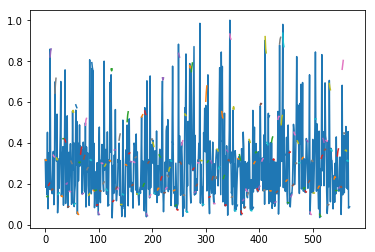

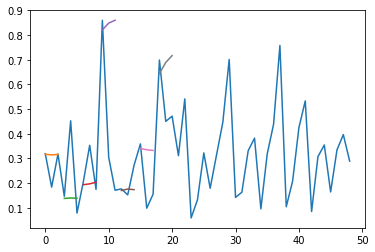

In [43]:
predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[::num_out]
true_train = train_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_train.tolist(), true_train, num_out)

utils.plot_results_multiple(predicted_train.tolist()[:7], true_train[:49], num_out)

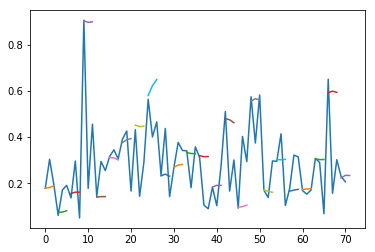

In [44]:
predicted_dev = model.predict(dev_X).squeeze()
predicted_train = predicted_train.reshape(predicted_train.shape[0], -1)
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_dev.tolist(), true_dev, num_out)

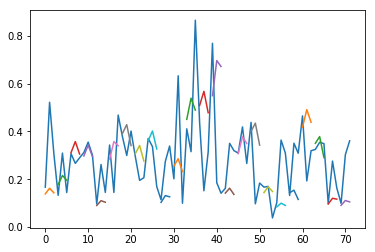

In [35]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[::num_out]
true_test = test_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

In [19]:
print("MSE Train:", mean_squared_error(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("MSE Test:", mean_squared_error(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

MSE Train: 0.043903049902005206
MSE Dev: 0.03273753104054841
MSE Test: 0.036268030889741114


In [20]:
print("Acc Train:", utils.direction_accuracy(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("Acc Dev:", utils.direction_accuracy(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("Acc Test:", utils.direction_accuracy(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

Acc Train: 0.5502645502645502
Acc Dev: 0.6
Acc Test: 0.5352112676056338


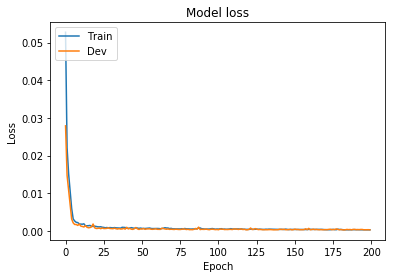

In [29]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()